In [1]:
from dust_emissivity import dust
from astropy.io import fits
from astropy import wcs
from astropy import units as u, coordinates
import regions
%matplotlib inline
import pylab as pl
# for bolocam (and maybe ATLASGAL?)
import radio_beam 
from spectral_cube import SpectralCube
import numpy as np

In [2]:
pwd

'/orange/adamginsburg/cmz/g5/code'

In [3]:
ls 

ALMA22/
BaselineFixes.ipynb
ContextImages.ipynb
ContextImages_bck.ipynb
ContextImages_bck2.ipynb
CopyRegionsExample.ipynb
DESPOTIC-2.1.tar.gz
DespoticSiO.ipynb
DistanceToG5.ipynb
LAMDA/
MakingSpectra.ipynb
MomentMaps.ipynb
PV_Diagrams.ipynb
RegionsExample.ipynb
Spectra.ipynb
Testing_dust_emissivity.ipynb
TryingGlueviz.ipynb
TryingPyRADEX.ipynb
TryingPyRADEX2.ipynb
arrayMoms.py*
bigreg.reg
combination.ipynb
combine_methods.py
core.ipython-11-1643745431-3663-3389-c0709a-s11.ufhpc.2852
core.python-11-1643147061-21287-3389-c0706a-s14.ufhpc.106037
core.python-11-1643147129-21287-3389-c0706a-s14.ufhpc.106468
core.python-11-1643148750-21287-3389-c0706a-s14.ufhpc.107148
core.python-11-1643381679-21287-3389-c0702a-s19.ufhpc.87038
despotic/
despotic_comp.inp
fitting.py*
footprint.reg
formalRatios.ipynb
f{key}_cutout.fits
g5-highvelo.reg
g5-lowvelo.reg
g5.12CO.spw17.fits
g5_code.py*
gasMassEstimate.ipynb
gmcChem.pdf
imcontsub.last*
importfits.last*
ipython_log_2021-11-30.py
ipython_log_2021-12-04

In [2]:
herfn_1 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_250_1342214761-1342214762_extd.fits'
herfn_2 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_350_1342214761-1342214762_extd.fits'
herfn_3 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_500_1342214761-1342214762_extd.fits'
pacsfn_1 = '/orange/adamginsburg/higal/Field4_0_PACS_SpirePacsParallel_160_1342214761-1342214762_jscanam.fits'
pacsfn_2 = '/orange/adamginsburg/higal/Field4_0_PACS_SpirePacsParallel_70_1342214761-1342214762_jscanam.fits'

In [107]:
#reg = regions.Regions.read('../G5/sum/spw17_12CO/ccc.reg')
reg = regions.Regions.read('/orange/adamginsburg/cmz/g5/code/bigreg.reg')
#reg = regions.Regions.read('/orange/adamginsburg/cmz/g5/code/g5-highvelo.reg')
#reg = regions.Regions.read('/orange/adamginsburg/cmz/g5/code/g5-lowvelo.reg')
#reg = regions.Regions.read('/orange/adamginsburg/cmz/g5/code/noisy.reg')
r0 = reg[0]
bgreg = regions.RectangleAnnulusSkyRegion(center=reg[0].center, inner_width=reg[0].width, inner_height=reg[0].height, outer_width=reg[0].width*2, outer_height=reg[0].height*2)



AttributeError: 'PolygonSkyRegion' object has no attribute 'center'

In [109]:
reg

<Regions([<PolygonSkyRegion(vertices=<SkyCoord (Galactic): (l, b) in deg
    [(5.48430805, -0.23679439), (5.48118714, -0.4314248 ),
     (5.27093884, -0.43038308), (5.27093954, -0.38354698),
     (5.40208377, -0.38354809), (5.40208389, -0.23679459)]>)>])>

In [93]:
bgreg

<RectangleAnnulusSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (5.33755219, -0.40722611)>, inner_width=475.8567 arcsec, outer_width=951.7134 arcsec, inner_height=174.231 arcsec, outer_height=348.462 arcsec, angle=0.0 deg)>

### $^{12}$CO

In [110]:
name_12co = '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.12CO.spw17.fits'
cube_12co = SpectralCube.read(name_12co).with_spectral_unit(u.km / u.s, velocity_convention='radio')


In [111]:
cut_cube_12co = cube_12co.with_mask(cube_12co>0.05*u.K).spectral_slab(0*u.km / u.second, 200*u.km/u.second).to(u.K)


In [112]:
mom0_12co = cut_cube_12co.moment0()

In [113]:
ww = wcs.WCS(mom0_12co.header)

In [114]:
preg = r0.to_pixel(ww)
mask = preg.to_mask()

In [115]:
cutout = mask.cutout(mom0_12co.data)

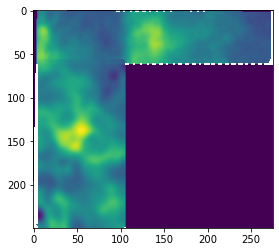

In [116]:
pl.imshow(mask.multiply(mom0_12co.data))

In [117]:
np.nanmean(mask.multiply(mom0_12co))

<Quantity 214.38711391 K km / s>

In [118]:
col_density = mask.multiply(mom0_12co) * 2.3*10**20 * u.cm**(-2) * (u.K * u.km / u.s)**(-1) * 0.8


In [119]:
pix_area = mom0_12co.wcs.celestial.proj_plane_pixel_area()


In [120]:
d=7*u.kpc
pix_area_cm = (pix_area * d**2).to(u.parsec**2, equivalencies=u.dimensionless_angles()).to(u.cm**2)


In [121]:
mass_conv = 2.8 * u.Da
mass_map = (col_density * pix_area_cm * mass_conv).to(u.M_sun)

In [122]:
np.nansum(mass_map)

<Quantity 542494.83073441 solMass>

### 160 $\mu$m

In [194]:
hdul = fits.open(pacsfn_1)

In [195]:
ww = wcs.WCS(hdul[1].header)

In [196]:
# preg is short for pixel region
preg = r0.to_pixel(ww)
mask = preg.to_mask()

In [197]:
cutout = mask.cutout(hdul[1].data)

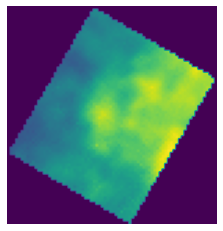

In [198]:
pl.axis('off')
pl.imshow(mask.multiply(hdul[1].data))#, cmap='afmhot')
pl.savefig('plots/160micron.png')

0.09666766140337787

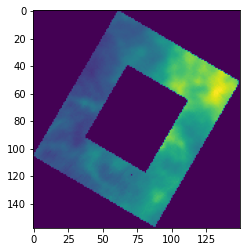

In [199]:
bgpreg = bgreg.to_pixel(ww)
bgmask = bgpreg.to_mask()
pl.imshow(bgmask.multiply(hdul[1].data))
bgim = bgmask.multiply(hdul[1].data)
bg = np.nanpercentile(bgim[bgim!=0], 10)
bg

In [200]:
hdul[1].header['BUNIT']

'Jy/pixel'

In [201]:
pixelarea = 1*u.pixel

In [202]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)

<Quantity 659.89015534 Jy>

In [203]:
pacs160 = (mask.multiply(hdul[1].data - bg) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)
pacs160

<Quantity 358.38371942 Jy>

In [204]:
#659.9 - 358.8

In [205]:
#(659.9 - 358.8)/659.9

In [206]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).std().to(u.Jy)

<Quantity 0.114353 Jy>

## 70 $\mu$m

In [207]:
hdul = fits.open(pacsfn_2)
ww = wcs.WCS(hdul[1].header)

In [31]:
# preg is short for pixel region
preg = r0.to_pixel(ww)
mask = preg.to_mask()

In [32]:
cutout = mask.cutout(hdul[1].data)

In [33]:
hdul[1].data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

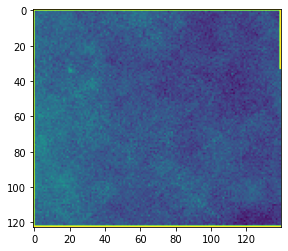

In [34]:
pl.imshow(mask.multiply(hdul[1].data))

-0.059626399527061426

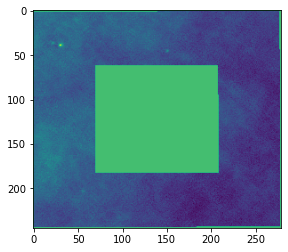

In [35]:
bgpreg = bgreg.to_pixel(ww)
bgmask = bgpreg.to_mask()
pl.imshow(bgmask.multiply(hdul[1].data))
bgim = bgmask.multiply(hdul[1].data)
bg = np.nanpercentile(bgim[bgim!=0], 10)
bg

In [36]:
hdul[1].header['BUNIT']

'Jy/pixel'

In [37]:
pixelarea = 1*u.pixel

In [38]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)

<Quantity -808.89294578 Jy>

In [39]:
pacs70 = (mask.multiply(hdul[1].data - bg) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)
pacs70

<Quantity 191.99579668 Jy>

In [40]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).std().to(u.Jy)

<Quantity 0.0090522 Jy>

## 350 $\mu$m

In [41]:
hdul = fits.open(herfn_2)
ww = wcs.WCS(hdul[1].header)

In [42]:
hdul[1].header['BUNIT']

'MJy/sr'

In [43]:
pixelarea = ww.proj_plane_pixel_area().to(u.sr)

In [44]:
pixelarea

<Quantity 2.35044305e-09 sr>

In [45]:
# preg is short for pixel region
preg = r0.to_pixel(ww)
mask = preg.to_mask()

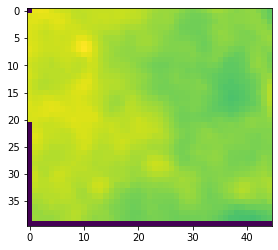

In [46]:
pl.imshow(mask.multiply(hdul[1].data))

187.38771767375056

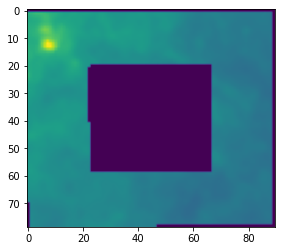

In [47]:
bgpreg = bgreg.to_pixel(ww)
bgmask = bgpreg.to_mask()
pl.imshow(bgmask.multiply(hdul[1].data))
bgim = bgmask.multiply(hdul[1].data)
bg = np.nanpercentile(bgim[bgim!=0], 10)
bg

In [48]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)

<Quantity 921.73882369 Jy>

In [49]:
her350 = (mask.multiply(hdul[1].data - bg) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)
her350

<Quantity 157.12776298 Jy>

In [50]:
#(hdul[1].data > 0.0).sum() * pixelarea

In [51]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).std().to(u.Jy)

<Quantity 0.10400883 Jy>

## 250 $\mu$m

In [52]:
hdul = fits.open(herfn_1)
ww = wcs.WCS(hdul[1].header)

In [53]:
hdul[1].header['BUNIT']

'MJy/sr'

In [54]:
pixelarea = ww.proj_plane_pixel_area().to(u.sr)

In [55]:
# preg is short for pixel region
preg = r0.to_pixel(ww)
mask = preg.to_mask()

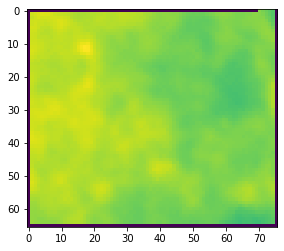

In [56]:
pl.imshow(mask.multiply(hdul[1].data))

434.04472052329277

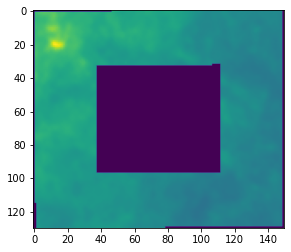

In [57]:
bgpreg = bgreg.to_pixel(ww)
bgmask = bgpreg.to_mask()
pl.imshow(bgmask.multiply(hdul[1].data))
bgim = bgmask.multiply(hdul[1].data)
bg = np.nanpercentile(bgim[bgim!=0], 10)
bg

In [58]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)

<Quantity 2102.58772422 Jy>

In [59]:
her250 = (mask.multiply(hdul[1].data - bg) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)
her250

<Quantity 361.35561246 Jy>

In [60]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).std().to(u.Jy)

<Quantity 0.10495919 Jy>

##  500 $\mu$m

In [61]:
hdul = fits.open(herfn_3)
ww = wcs.WCS(hdul[1].header)

In [62]:
hdul[1].header['BUNIT']

'MJy/sr'

In [63]:
pixelarea = ww.proj_plane_pixel_area().to(u.sr)

In [64]:
# preg is short for pixel region
preg = r0.to_pixel(ww)
mask = preg.to_mask()

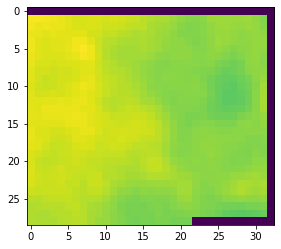

In [65]:
pl.imshow(mask.multiply(hdul[1].data))

63.4516026192808

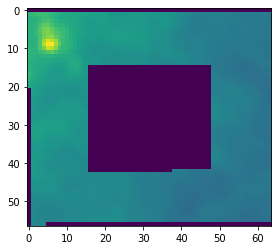

In [66]:
bgpreg = bgreg.to_pixel(ww)
bgmask = bgpreg.to_mask()
pl.imshow(bgmask.multiply(hdul[1].data))
bgim = bgmask.multiply(hdul[1].data)
bg = np.nanpercentile(bgim[bgim!=0], 10)
bg

In [67]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)

<Quantity 313.65427299 Jy>

In [68]:
her500 = (mask.multiply(hdul[1].data - bg) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).sum().to(u.Jy)
her500

<Quantity 54.66479363 Jy>

In [69]:
(mask.multiply(hdul[1].data) *u.Unit(hdul[1].header['BUNIT']) * pixelarea).std().to(u.Jy)

<Quantity 0.09541114 Jy>

## Bolocam and ATLASGAL

##### Bolocam

In [159]:
bolo_1 = '/orange/adamginsburg/galactic_plane_surveys/bolocam/data/BOLOCAM_GPS/images/v2/INNER_GALAXY/map/v2.0_ds2_l006_13pca_map20.fits'
#v2.0_ds2_l004_13pca_map20.fits'
'/orange/adamginsburg/galactic_plane_surveys/bolocam/v2.0_ds2_l004_13pca_map20_crop.fits'
#bolo_2 = ''
'/orange/adamginsburg/galactic_plane_surveys/bolocam/v2.0_ds2_l006_13pca_map20_crop.fits'

# 1.1 mm


'/orange/adamginsburg/galactic_plane_surveys/bolocam/v2.0_ds2_l006_13pca_map20_crop.fits'

In [173]:
reg_bolo = regions.Regions.read('/orange/adamginsburg/cmz/g5/code/bolonoise.reg')
r0_bolo = reg_bolo[0]
bgreg_bolo = regions.RectangleAnnulusSkyRegion(center=reg_bolo[0].center, inner_width=reg_bolo[0].width, inner_height=reg_bolo[0].height, outer_width=reg_bolo[0].width*2, outer_height=reg_bolo[0].height*2)


In [174]:
hdul = fits.open(bolo_1)
ww = wcs.WCS(hdul[0].header)

In [175]:
hdul[0].header['BUNIT'] 

'Jy/Beam'

In [176]:
hdul[0].header['PPBEAM']

23.8027621852

In [177]:
pixelarea = ww.proj_plane_pixel_area().to(u.sr)
#pixelarea = 1*u.pixel

In [178]:
pixelarea

<Quantity 1.21846951e-09 sr>

In [179]:
# preg is short for pixel region
preg = r0.to_pixel(ww)
mask = preg.to_mask()

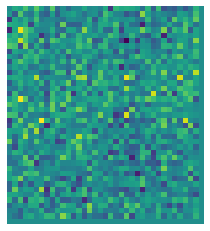

In [180]:
pl.axis('off')
pl.imshow(mask.multiply(hdul[0].data))
pl.savefig('plots/bolocam.png')

-0.2937002271413803

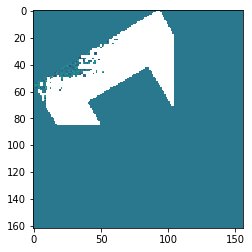

In [181]:
bgpreg = bgreg.to_pixel(ww)
bgmask = bgpreg.to_mask()
pl.imshow(bgmask.multiply(hdul[0].data))
bgim = bgmask.multiply(hdul[0].data)
bg = np.nanpercentile(bgim[bgim!=0], 10)
bg

In [79]:
#(mask.multiply(hdul[0].data) *u.Unit(hdul[0].header['BUNIT']) * pixelarea).sum().to(u.Jy)

(mask.multiply(hdul[0].data) / hdul[0].header['PPBEAM']).sum() * u.Jy

<Quantity nan Jy>

In [80]:
bolo11 = (mask.multiply(hdul[0].data - bg) / hdul[0].header['PPBEAM']).sum() * u.Jy
bolo11

<Quantity nan Jy>

In [81]:
#beam

In [182]:
(mask.multiply(hdul[0].data) / hdul[0].header['PPBEAM']).std() * u.Jy

<Quantity 0.00242735 Jy>

##### ATLASGAL

In [82]:
atlas = '/orange/adamginsburg/galactic_plane_surveys/atlasgal/AG-Laboca-Planck.4.5.fits'
# Planck 353 GHz Survey
# 850 microns

In [83]:
agalhdul = hdul = fits.open(atlas)
agalww = ww = wcs.WCS(hdul[0].header)

In [84]:
hdul[0].header['BUNIT']

'JY/BEAM'

In [85]:
beam = radio_beam.Beam.from_fits_header(hdul[0].header)

In [86]:
beam.sr

<Quantity 1.17442275e-08 sr>

In [87]:
pixelarea = ww.proj_plane_pixel_area().to(u.sr)
pixelarea

<Quantity 2.68134526e-10 sr>

In [88]:
# preg is short for pixel region
preg = r0.to_pixel(ww)
mask = preg.to_mask()

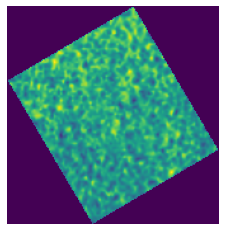

In [89]:
pl.axis('off')
pl.imshow(mask.multiply(hdul[0].data))
pl.savefig('plots/atlasgal.png')

In [90]:
(mask.multiply(hdul[0].data) * u.Jy / beam.sr * pixelarea).sum().to(u.Jy)

<Quantity 64.40224742 Jy>

0.13467442393302917

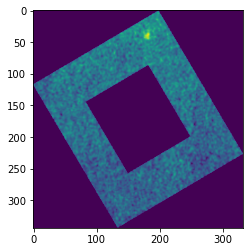

In [91]:
bgpreg = bgreg.to_pixel(ww)
bgmask = bgpreg.to_mask()
pl.imshow(bgmask.multiply(hdul[0].data))
bgim = bgmask.multiply(hdul[0].data)
bg = np.nanpercentile(bgim[bgim!=0], 10)
bg

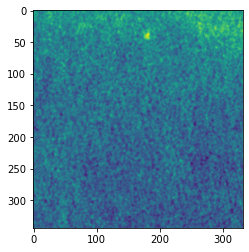

In [92]:
pl.imshow(bgmask.cutout(hdul[0].data))

In [93]:
(mask.multiply(hdul[0].data) * u.Jy * beam.sr / pixelarea).sum().to(u.Jy)

<Quantity 123550.48597593 Jy>

In [94]:
atlas850 = (mask.multiply(hdul[0].data - bg) * u.Jy / beam.sr * pixelarea).sum().to(u.Jy)
atlas850

<Quantity 18.15454738 Jy>

In [95]:
(beam.sr / pixelarea).decompose()

<Quantity 43.79975866>

In [96]:
(mask.multiply(hdul[0].data) * u.Jy / beam.sr * pixelarea).std().to(u.Jy)

<Quantity 0.00222678 Jy>

## PPMAP

In [97]:
## ...which file?
ppmap = '/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/'

## SED Fitting

In [98]:
(160*u.micron, 659.89016*u.Jy) # pacsfn_1
(70*u.micron, 8.9645548*u.Jy) # pacsfn_1
(350*u.micron, 531.67255*u.Jy) # herfn_2
(250*u.micron, 1104.3927*u.Jy) # herfn_1
(500*u.micron, 203.23191*u.Jy) # herfn_3
(1.1*u.mm, 2.4610367*u.Jy) # Bolocam
((353 * u.GHz).to(u.mm, equivalencies=u.spectral()), 50.280185*u.Jy) # ATLASGAL

(<Quantity 0.84927042 mm>, <Quantity 50.280185 Jy>)

In [99]:
(1104.3927*u.Jy-2.4610367*u.Jy)/(250*u.micron-(1.1*u.mm).to(u.micron))

<Quantity -1.29639019 Jy / micron>

In [100]:
(1104.3927*u.Jy-50.280185*u.Jy)/(250*u.micron-(353 * u.GHz).to(u.micron, equivalencies=u.spectral()))

<Quantity -1.75899307 Jy / micron>

In [101]:
(1.1*u.mm).to(u.micron)

<Quantity 1100. micron>

In [102]:
(353 * u.GHz).to(u.micron, equivalencies=u.spectral())

<Quantity 849.27041926 micron>

In [103]:
#  log(flux ratio)/log(nu ratio) = alpha
# Bolocam
np.log(1104.3927/2.4610367)/np.log(250/1100)

-4.121523670794213

In [104]:
# (500*u.micron, 203.23191*u.Jy) # herfn_3
np.log(203.23191/2.4610367)/np.log(500/1100)

-5.597975589704405

In [105]:
# ATLASGAL
np.log(1104.3927/50.280185)/np.log(250/850)

-2.524515304988999

In [106]:
np.log(203.23191/50.280185)/np.log(500/850)

-2.632232028487509

In [107]:
np.log(50.280185/2.4610367)/np.log(850/1100)

-11.701659239883302

In [108]:
pacs160

<Quantity 690.54000925 Jy>

In [109]:
pacs70

<Quantity 191.99579668 Jy>

In [110]:
her350

<Quantity 157.12776298 Jy>

In [111]:
her250

<Quantity 361.35561246 Jy>

In [112]:
her500

<Quantity 54.66479363 Jy>

In [113]:
bolo11

<Quantity nan Jy>

In [114]:
atlas850

<Quantity 18.15454738 Jy>

In [115]:
sed = [(160*u.micron, pacs160, 'pacs', '160 um'), # pacsfn_1
(70*u.micron, pacs70, 'pacs', '70 um'), # pacsfn_1
(350*u.micron, her350, 'Herschel', '350 um'), # herfn_2
(250*u.micron, her250, 'Herschel', '250 um'), # herfn_1
(500*u.micron, her500, 'Herschel', '500 um'), # herfn_3
((1.1*u.mm).to(u.micron), bolo11, 'Bolocam' ,'1.1 mm'), # Bolocam
(850*u.micron, atlas850, 'ATLASGAL', '850 um')] # ATLASGAL
#((353 * u.GHz).to(u.micron, equivalencies=u.spectral()), atlas850, 'ATLASGAL', '850 um')] # ATLASGAL

In [116]:
print(sed)

[(<Quantity 160. micron>, <Quantity 690.54000925 Jy>, 'pacs', '160 um'), (<Quantity 70. micron>, <Quantity 191.99579668 Jy>, 'pacs', '70 um'), (<Quantity 350. micron>, <Quantity 157.12776298 Jy>, 'Herschel', '350 um'), (<Quantity 250. micron>, <Quantity 361.35561246 Jy>, 'Herschel', '250 um'), (<Quantity 500. micron>, <Quantity 54.66479363 Jy>, 'Herschel', '500 um'), (<Quantity 1100. micron>, <Quantity nan Jy>, 'Bolocam', '1.1 mm'), (<Quantity 850. micron>, <Quantity 18.15454738 Jy>, 'ATLASGAL', '850 um')]


In [117]:
#sed = [pacs160, pacs70, her350, her250, her500, bolo11, atlas850]

In [118]:
(353 * u.GHz).to(u.micron, equivalencies=u.spectral())

<Quantity 849.27041926 micron>

In [119]:
freq = (np.linspace(70, 1100, num=100)*u.micron)#.to(u.GHz, equivalencies=u.spectral())
tau = 1

In [120]:
import astropy.constants as const
def planck_freq(nu, T):
    nu = nu.to(u.Hz, equivalencies=u.spectral())
    return (2 * const.h * nu**3 / const.c**2 ) * (np.exp(const.h*nu/(const.k_B*T)) - 1)**(-1)

def planck_func(lamb, T):
    lamb = lamb.to(u.m, equivalencies=u.spectral())
    return (2*const.h*const.c**2 / lamb.to(u.m)**5) * (np.exp((const.h*const.c) / (lamb * const.k_B * T)) - 1)**(-1)

#def Ray_Jeans():

def blackbody(freq, beta, T):
    b = planck_freq(freq, T)
    mb = b * freq**(beta)
    return mb

#bb = blackbody(freq, 2, 10*u.K)# * u.sr**(-1) * (0.0020285287 * u.sr)

In [121]:
r0

<RectangleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (268.26311519, -24.80525823)>, width=442.7754 arcsec, height=387.4292 arcsec, angle=0.0 deg)>

In [122]:
from astropy.modeling import models
from astropy import units as u
freq = (np.geomspace(70, 1100, num=100)*u.micron)#.to(u.GHz, equivalencies=u.spectral())
bb = models.BlackBody(temperature=10*u.K)
bb = bb(freq.to(u.Hz, equivalencies=u.spectral()))
# 10−23 erg⋅s−1⋅cm−2⋅Hz−1
#help(r0)
area = (r0.height*r0.width).to(u.sr)
bb = (bb*area).to(u.Jy)
beta=1
nu=freq.to(u.Hz, equivalencies=u.spectral())
#mbb = bb*(nu/nu.min())**beta

In [123]:
area.to(u.arcmin**2)

<Quantity 47.65114417 arcmin2>

(1, 5000.0)

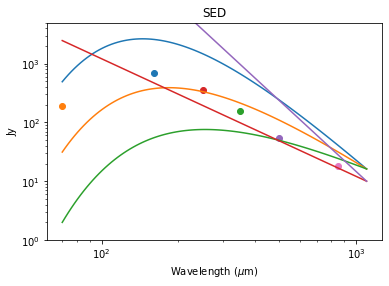

In [124]:
for point in sed: 
    #pl.scatter(point[0].to(u.GHz, equivalencies=u.spectral()), point[1], label=point[2])
    pl.scatter(point[0], point[1], label=point[2])
    #pl.legend()
  
pl.yscale('log')
pl.xscale('log')
pl.xlabel('Wavelength ($\mu$m)')
#pl.xlabel('Frequency (GHz)')
pl.ylabel('Jy')
bb = planck_freq(freq.to(u.Hz, u.spectral()), 20*u.K)*5e16
#pl.plot()
pl.plot(freq.to(u.micron, equivalencies=u.spectral()), bb*(nu/nu.min())**2)
pl.plot(freq.to(u.micron, equivalencies=u.spectral()), bb*(nu/nu.min())**1)
pl.plot(freq.to(u.micron, equivalencies=u.spectral()), bb)
pl.plot(freq.to(u.um, u.spectral()), (nu/nu.min())**2 * 10)
pl.plot(freq.to(u.um, u.spectral()), (nu/nu.min())**4 * 10)
pl.title('SED')
pl.ylim(1,5e3)

In [125]:
bb

<Quantity [ 1.99325497,  2.43102492,  2.94209464,  3.53392307,  4.21386728,
            4.9890243 ,  5.86606369,  6.85105515,  7.94929605,  9.16514387,
           10.50185887, 11.96146181, 13.54461149, 15.2505063 , 17.07681304,
           19.01962593, 21.0734572 , 23.23126027, 25.48448502, 27.82316409,
           30.23602799, 32.71064605, 35.23358964, 37.79061353, 40.36685068,
           42.94701598, 45.51561387, 48.05714535, 50.5563099 , 52.9981981 ,
           55.36847157, 57.65352703, 59.84064196, 61.91810014, 63.87529577,
           65.7028155 , 67.39249831, 68.93747374, 70.33217921, 71.5723579 ,
           72.65503853, 73.57849904, 74.34221608, 74.94680232, 75.3939338 ,
           75.68626926, 75.82736363, 75.82157744, 75.67398402, 75.3902761 ,
           74.97667312, 74.43983076, 73.7867535 , 73.02471124, 72.16116071,
           71.20367211, 70.15986147, 69.03732892, 67.84360308, 66.58609142,
           65.27203671, 63.9084793 , 62.50222494, 61.05981803, 59.58751984,
           5

In [126]:
point

(<Quantity 850. micron>, <Quantity 18.15454738 Jy>, 'ATLASGAL', '850 um')

In [127]:
#u.Unit(hdul[0].header['BUNIT']) * pixelarea

# erg/s/cm2/Angstrom/steradian


In [128]:
# for bolocam (and maybe ATLASGAL?)
import radio_beam 

In [129]:
from spectral_cube import SpectralCube

In [130]:
cube = SpectralCube.read('../G5/sum/spw17_12CO/g5.12CO.spw17.im', format='casa_image')

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [131]:
beam = cube.beam

In [132]:
beam.jtok(cube.spectral_axis) * 350 

<Quantity [10.11410048, 10.11408977, 10.11407905, ..., 10.09221839,
           10.09220771, 10.09219703] K>

In [133]:
beam

Beam: BMAJ=28.2287919999996 arcsec BMIN=28.2287919999996 arcsec BPA=30.19542724110654 deg

In [134]:
agalww

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 4.5  0.0  
CRPIX : 1324.0  1527.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.000938207719922  0.000938207719922  
NAXIS : 2647  3054

In [135]:
coordinates.SkyCoord([(x*u.deg) for x in cube.wcs.celestial.calc_footprint(agalhdul[0].header)], frame='galactic')

<SkyCoord (Galactic): (l, b) in deg
    [(5.48373485, -0.43198972), (5.48391308,  3.64186539),
     (1.94669156,  3.64246849), (1.95356697, -0.43138927)]>

In [136]:
# why didn't this work?  The world may never know.
footprint = regions.PolygonSkyRegion(coordinates.SkyCoord([(x*u.deg) for x in cube.wcs.celestial.calc_footprint(agalhdul[0].header)], frame='galactic'))

In [137]:
footprint = regions.Regions.read('footprint.reg')
footprint = footprint[0] | footprint[1]
footprint

<CompoundSkyRegion(region1=Region: RectangleSkyRegion
center: <SkyCoord (Galactic): (l, b) in deg
    (5.443749, -0.33346)>
width: 277.0856 arcsec
height: 671.9766 arcsec
angle: 0.0 deg, region2=Region: RectangleSkyRegion
center: <SkyCoord (Galactic): (l, b) in deg
    (5.339672, -0.407246)>
width: 481.3272 arcsec
height: 154.4402 arcsec
angle: 0.0 deg, operator=<built-in function or_>)>

In [138]:
footprint_pix = footprint.to_pixel(agalww)

In [139]:
footprint_pix

<CompoundPixelRegion(region1=Region: RectanglePixelRegion
center: PixCoord(x=317.00277879021996, y=1170.5254080618492)
width: 82.05141383527044
height: 198.98771388414983
angle: -3.739444309758255e-10 deg, region2=Region: RectanglePixelRegion
center: PixCoord(x=427.9614072493372, y=1091.8780178410116)
width: 142.53038755997534
height: 45.7327605022947
angle: 5.851234163856134e-09 deg, operator=<built-in function or_>)>

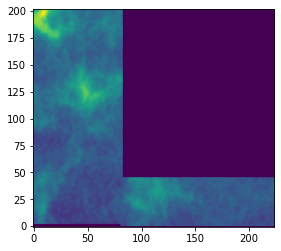

In [140]:
pl.imshow(footprint_pix.to_mask().multiply(agalhdul[0].data), origin='lower')

In [141]:
ls *.reg

bigreg.reg  footprint.reg  g5-highvelo.reg  g5-lowvelo.reg  noisy.reg


In [142]:
import dust_emissivity

In [143]:
dust_emissivity.dust.massofsnu?

Signature:
dust_emissivity.dust.massofsnu(
    nu,
    snu,
    distance=<Quantity 1. kpc>,
    temperature=<Quantity 20. K>,
    muh2=2.8,
    beta=1.75,
    beamomega=<Quantity 1. sr>,
)
Docstring: <no docstring>
File:      /blue/adamginsburg/adamginsburg/repos/dust_emissivity/dust_emissivity/dust.py
Type:      function


In [144]:
dust_emissivity.dust.massofsnu(271.1*u.GHz, 4.7052907*u.Jy, 7*u.kpc, temperature=10*u.K)

<Quantity 8812.07200452 solMass>

In [145]:
dust_emissivity.dust.massofsnu(271.1*u.GHz, 4.7052907*u.Jy, 7*u.kpc, temperature=20*u.K)

<Quantity 3021.38184981 solMass>

In [146]:
dust_emissivity.dust.massofsnu(271.1*u.GHz, 2.5*u.Jy, 7*u.kpc, temperature=10*u.K)

<Quantity 4682.00208202 solMass>

In [147]:
dust_emissivity.dust.massofsnu(271.1*u.GHz, 2.5*u.Jy, 7*u.kpc, temperature=10*u.K, beta=1.0)

<Quantity 4682.00208202 solMass>

In [148]:
dust_emissivity.dust.massofsnu(271.1*u.GHz, 2.5*u.Jy, 7*u.kpc, temperature=10*u.K, beta=2.0)

<Quantity 4682.00208202 solMass>

In [149]:
(870*u.um).to(u.GHz, u.spectral())

<Quantity 344.58903218 GHz>

In [150]:
dust_emissivity.dust.massofsnu(345*u.GHz, 50*u.Jy, 7*u.kpc, temperature=10*u.K, beta=2.0)

<Quantity 44466.04165556 solMass>

In [151]:
dust_emissivity.dust.massofsnu(345*u.GHz, 50*u.Jy, 7*u.kpc, temperature=10*u.K, beta=1.0)

<Quantity 56587.17953215 solMass>

In [152]:
dust_emissivity.dust.massofsnu(345*u.GHz, 50*u.Jy, 7*u.kpc, temperature=20*u.K, beta=1.0)

<Quantity 17207.92081284 solMass>

In [153]:
dust_emissivity.dust.massofsnu(345*u.GHz, 50*u.Jy, 7*u.kpc, temperature=20*u.K, beta=2.0)

<Quantity 13521.9342967 solMass>

In [154]:
pacs160_1 = 358.38372 * u.Jy
pacs70_1 = 31.272129 * u.Jy
her350_1 = 184.0481 * u.Jy
her250_1 = 320.71168 * u.Jy
her500_1 = 78.398848 * u.Jy
bolo11_1 = 4.7052907 * u.Jy
atlas850_1 = 22.663 * u.Jy

In [155]:
sed_1 = [(160*u.micron, pacs160_1, 'pacs', '160 um'), # pacsfn_1
(70*u.micron, pacs70_1, 'pacs', '70 um'), # pacsfn_1
(350*u.micron, her350_1, 'Herschel', '350 um'), # herfn_2
(250*u.micron, her250_1, 'Herschel', '250 um'), # herfn_1
(500*u.micron, her500_1, 'Herschel', '500 um'), # herfn_3
((1.1*u.mm).to(u.micron), bolo11_1, 'Bolocam' ,'1.1 mm'), # Bolocam
(850*u.micron, atlas850_1, 'ATLASGAL', '850 um')] # ATLASGAL
#((353 * u.GHz).to(u.micron, equivalencies=u.spectral()), atlas850_1, 'ATLASGAL', '850 um')] # ATLASGAL

In [156]:
sed

[(<Quantity 160. micron>, <Quantity 690.54000925 Jy>, 'pacs', '160 um'),
 (<Quantity 70. micron>, <Quantity 191.99579668 Jy>, 'pacs', '70 um'),
 (<Quantity 350. micron>, <Quantity 157.12776298 Jy>, 'Herschel', '350 um'),
 (<Quantity 250. micron>, <Quantity 361.35561246 Jy>, 'Herschel', '250 um'),
 (<Quantity 500. micron>, <Quantity 54.66479363 Jy>, 'Herschel', '500 um'),
 (<Quantity 1100. micron>, <Quantity nan Jy>, 'Bolocam', '1.1 mm'),
 (<Quantity 850. micron>, <Quantity 18.15454738 Jy>, 'ATLASGAL', '850 um')]

In [157]:
modfit = dust_emissivity.fit_sed.fit_modified_bb(xdata=u.Quantity([p[0] for p in sed]).to(u.Hz, u.spectral()),
                                        flux=u.Quantity([p[1] for p in sed]),
                                        error=u.Quantity([1*u.Jy for p in sed]),
                                        guesses=[50*u.K, 2, 1e22*u.cm**-2],
                                        fitter='lmfit'
                                       )

UnitConversionError: 'Jy' (spectral flux density) and 'erg / (cm2 Hz s sr)' are not convertible

In [ ]:
modfit

In [ ]:
sed_1

In [ ]:
modfit_1 = dust_emissivity.fit_sed.fit_modified_bb(xdata=u.Quantity([p[0] for p in sed_1]).to(u.Hz, u.spectral()),
                                        flux=u.Quantity([p[1] for p in sed_1]),
                                        error=u.Quantity([1*u.Jy for p in sed_1]),
                                        guesses=[50*u.K, 2, 1e22*u.cm**-2],
                                        fitter='lmfit'
                                       )

In [ ]:
modfit_1

In [ ]:
flux=u.Quantity([p[1] for p in sed])
error=u.Quantity([(1*u.Jy) for p in sed])

In [ ]:
#help(dust_emissivity.fit_sed.fit_modified_bb)

In [ ]:
(1*u.Jy).to(u.erg/u.second/u.cm**2/u.Hz)

In [ ]:
modfit

In [ ]:
pl.plot(freq.to(u.Hz, u.spectral()), 
          dust_emissivity.blackbody.modified_blackbody(freq.to(u.Hz, u.spectral()), 
                                                       temperature=modfit[0], beta=modfit[1],column=modfit[2]))
pl.scatter(u.Quantity([p[0] for p in sed_1]).to(u.Hz, u.spectral()), u.Quantity([p[1] for p in sed_1]))
pl.yscale('log')
pl.xscale('log')

In [ ]:
pl.scatter(u.Quantity([p[0] for p in sed_1]).to(u.micron, u.spectral()), u.Quantity([p[1] for p in sed_1]))
pl.yscale('log')
pl.xscale('log')
pl.plot(freq.to(u.micron, u.spectral()), 
          dust_emissivity.blackbody.modified_blackbody(freq.to(u.Hz, u.spectral()), 
                                                       temperature=modfit_1[0], beta=modfit_1[1],column=1e22*u.cm**-2))

In [ ]:
# modified_blackbody(frequencies, temperature, beta=0, column=1e22*u.cm**-2)
pl.loglog(freq.to(u.Hz, u.spectral()), 
          dust_emissivity.blackbody.modified_blackbody(freq.to(u.Hz, u.spectral()), 
                                                       temperature=modfit_1[0], beta=modfit_1[1],column=modfit_1[2]))

In [ ]:
modfit_laptop = [12.76225787 * u.K, 2.524787732161178, 7.08477196e+15 / u.cm**2]

In [ ]:
pl.loglog(freq.to(u.Hz, u.spectral()), 
          dust_emissivity.blackbody.modified_blackbody(freq.to(u.Hz, u.spectral()), 
                                                       temperature=modfit_laptop[0], beta=modfit_laptop[1],column=modfit_laptop[2]))
#pl.loglog(freq.to(u.Hz, u.spectral()), u.Quantity([p[1] for p in sed]))

In [ ]:
freq

In [ ]:
#python -c "import dust_emissivity; print(dust_emissivity.__version__)"
print(dust_emissivity.__version__)

In [ ]:
import astropy
print(astropy.__version__)

In [ ]:
import scipy
print(scipy.__version__)

In [ ]:
pwd

In [ ]:
import lmfit
print(lmfit.__version__)

In [ ]:
for row in sed:
    for item in row:
        print(item, type(item))

In [ ]:
for row in sed_1:
    for item in row:
        print(item, type(item))

In [ ]:
print(u.Quantity([np.round(p[0]) for p in sed]).to(u.Hz, u.spectral()))
print(u.Quantity([np.round(p[1]) for p in sed]))

In [ ]:
print(u.Quantity([p[0] for p in sed_1]).to(u.Hz, u.spectral()))
print(u.Quantity([p[1] for p in sed_1]))

In [ ]:
modfit_what = dust_emissivity.fit_sed.fit_modified_bb(xdata=u.Quantity([p[0] for p in sed_1]).to(u.Hz, u.spectral()),
                                        flux=u.Quantity([p[1] for p in sed_1]),
                                        error=u.Quantity([1*u.Jy for p in sed_1]),
                                        guesses=[50*u.K, 2, 1e22*u.cm**-2],
                                        fitter='lmfit'
                                       )
modfit_what

In [ ]:
modfit_what2 = dust_emissivity.fit_sed.fit_modified_bb(xdata=u.Quantity([p[0] for p in sed]).to(u.Hz, u.spectral()),
                                        flux=u.Quantity([p[1]*1.00001 for p in sed]),
                                        error=u.Quantity([1*u.Jy for p in sed]),
                                        guesses=[50*u.K, 2, 1e22*u.cm**-2],
                                        fitter='lmfit'
                                       )
modfit_what2

In [ ]:
[p[1]*1.00001 for p in sed]

In [ ]:
[p[1] for p in sed]

In [ ]:
[np.round(p[0]) for p in sed_1]